<a href="https://colab.research.google.com/github/varsita-yeddula/AIML_Learnings/blob/main/STP_Module_2_Lab_3_Manifold_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods

---



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

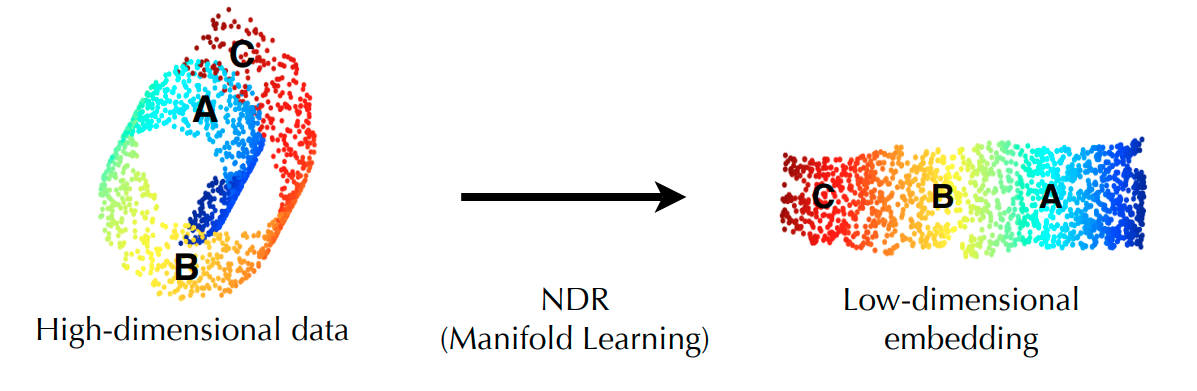

**What is a Manifold?**

**Analogy:**

Imagine you’re an ant walking on a globe. To you, the surface seems flat, but in reality, it’s curved. The globe is a manifold: locally flat, but globally curved. Manifold learning tries to "unroll" this globe into a flat map, preserving the true distances as much as possible.

**Why do we care?**

High-dimensional data (e.g., images, text, or sensor data) often lies on a lower-dimensional "surface" (manifold) embedded in a high-dimensional space.
Manifold learning helps us discover and visualize this hidden structure.

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



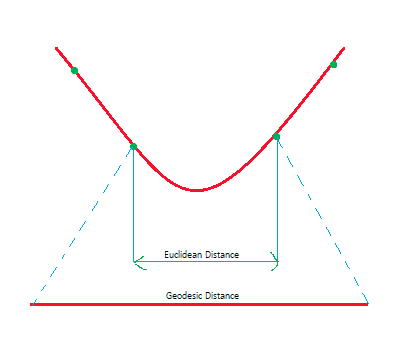

**Euclidean vs. Geodesic Distances:**

- Euclidean distance: Straight-line distance between two points.
- Geodesic distance: Shortest path along the surface of the manifold.

**Example:**

On Earth, the Euclidean distance between two cities is a straight line through the planet (useless!). The geodesic distance is the great-circle distance (what GPS uses).

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


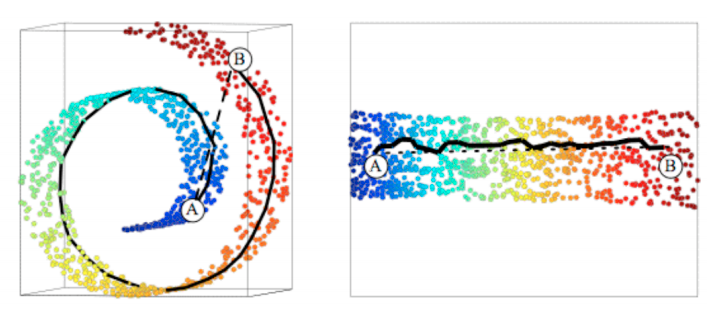

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


**What is Isomap?**

Isomap is like a GPS for data points. Instead of using straight-line (Euclidean) distances, it uses "road distances" (geodesic distances) to map the data.
It’s useful when data points are connected in a non-linear way (e.g., a curved surface).

**Example:**

Think of a piece of paper rolled into a tube. If you measure distances along the paper (not through the air), you’re using geodesic distances. Isomap tries to "flatten" the tube while keeping these distances accurate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

**Why use the S-curve?**

The S-curve is a classic example of a 2D manifold embedded in 3D space.
It’s non-linear, so linear methods like PCA struggle to "unroll" it, but Isomap can.

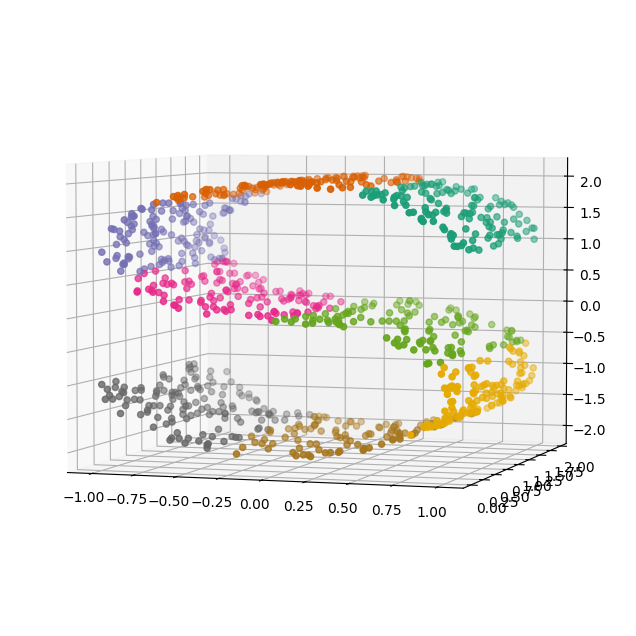

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

**Observation:**

- The S-curve is a 2D surface (a sheet of paper) bent in 3D space.
- Isomap will try to "unbend" this surface into a flat 2D plane.

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [4]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(1000, 1000)


**What’s happening?**

- We compute the Euclidean distance between every pair of points.
- This gives us an N x N matrix, where N is the number of points (1000 here).

### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [5]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [6]:
neighbors.shape

(1000, 1000)

**Adjacency Graph**

**What’s happening?**

- We connect each point to its k nearest neighbors, creating a network (graph).
- This graph approximates the true shape of the manifold.

**Analogy:**

Imagine you’re in a maze. You can only see nearby walls (neighbors). By connecting to your neighbors, you can find the shortest path to any other point in the maze.



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [7]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

**Dijkstra’s Algorithm**

**What’s happening?**

- We calculate the shortest path between every pair of points using Dijkstra’s algorithm.
- This gives us the "true" distances along the manifold, not just straight-line distances.

**Example:**

If you’re driving from Delhi to Mumbai, the road distance (geodesic) is longer than the straight-line (Euclidean) distance on a map. Isomap uses the road distance.



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [8]:
gram = (graph ** 2)

We will now be computing the eigenvectors for this matrix, so lets first center the data points.

In [9]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [10]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

**Eigenvectors and the Gram Matrix**

**What’s happening?**

- We compute the Gram matrix (a matrix of inner products) and find its top eigenvectors.
- These eigenvectors give us the coordinates in the lower-dimensional space.

**Analogy:**

Think of the Gram matrix as a "distortion detector." The top eigenvectors help us "unfold" the manifold into a flat space.



---

## Plotting the resultant reduced_matrix


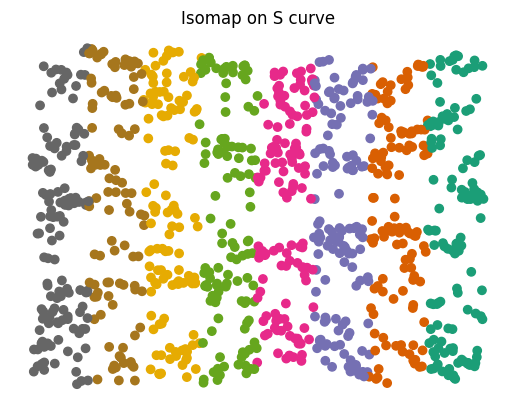

In [11]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

**Isomap on the S-Curve**

**What’s happening in the code?**

- We generate a 3D S-shaped curve.
- We compute pairwise distances and keep only the k nearest neighbors.
- We use Dijkstra’s algorithm to find the shortest paths (geodesics).
- We reduce the data to 2D using eigenvectors.

**Visualization:**

The 3D S-curve is "unrolled" into a 2D plane, preserving the structure.

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [12]:
from sklearn.manifold import Isomap

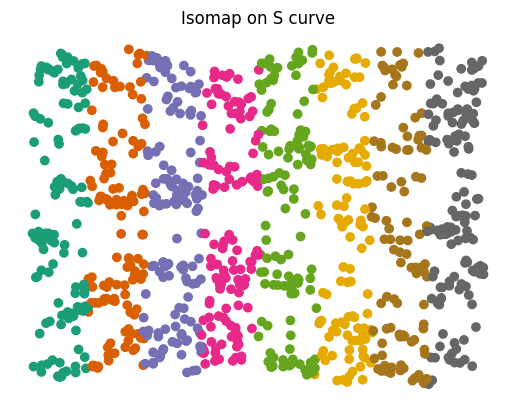

In [13]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

**Why Use sklearn?**
**Why use sklearn's Isomap?**

- The manual implementation helps you understand the math, but sklearn is optimized and easier to use.
- It’s also more robust for real-world datasets.



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [14]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

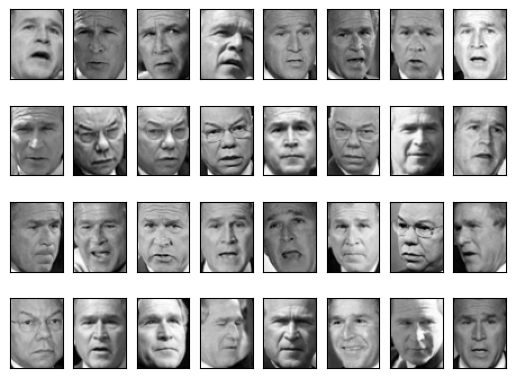

In [15]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

**Why Faces?**
**Why use Isomap on faces? **

- Faces are high-dimensional (2914 pixels), but the meaningful variations (e.g., orientation, lighting) lie on a lower-dimensional manifold.
- Isomap reveals these hidden structures.

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

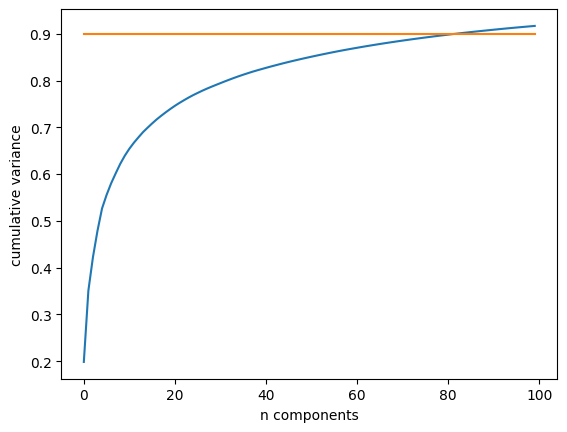

In [16]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [17]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [18]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

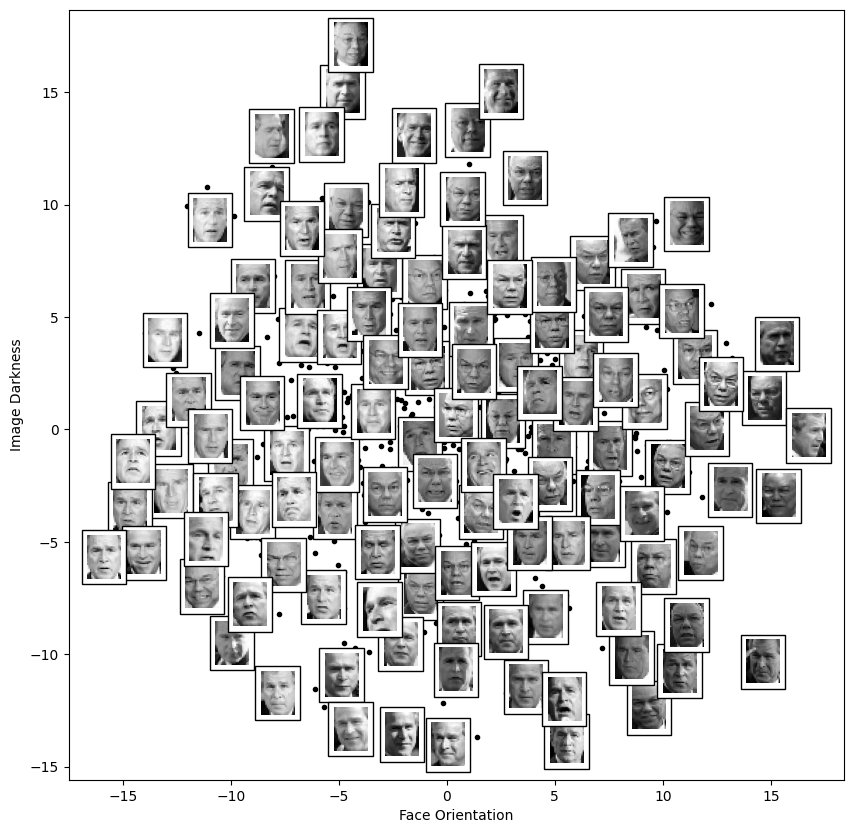

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 30),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

**PCA vs. Isomap on Faces**

**Observation:**

- PCA needs 70+ dimensions to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.
- Isomap reduces the data to 2D while preserving meaningful structure (orientation and darkness).

**Interpreting the Face Plot**

**Observation:**

- The 2D plot shows faces arranged by orientation (left to right) and darkness (bottom to top).
- This means Isomap discovered two key features without being told what to look for!

**Example:**

If you sort photos of a person’s face from bright to dark and left-profile to right-profile, you’re doing what Isomap does automatically.



**You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!**

---


# Exercises!!

1. How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

2. When is the ISOMAP algorithm superior to PCA?

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

4. Suggest ways to deal with missing data in manifold learning.


---

# Answers to Exercies

1. The number of neighbors effect the isomap algorithm as it defines how many neighboring points to consider for evaluation.

If the value of 'k' is very high, almost all points are considered as neighbors fore very point which make the geodesic distances resemble euclidean distances. Hence, the ISOMAP might behave similar to PCA

If the value of k is too low, the characteristics of neighboring points might not be evaluated properly and the algorithm will be vulnerable to outliers leading to unstable results

2. ISOMAP is superior to PCA when the data is non-linear. As PCA calculates euclidean distances, it doesn't work accurately with non-linear data unlike ISOMAP which uses geodesic distances

3. Other manifold learning methods include:

- *t-SNE (t-Distributed Stochastic Neighbor Embedding)*: t-SNE works on the principle to preserve local neighborhoods. It is different from ISOMAP as it doesn't preserve the global manifold structure. Also, it is mainly used for visualization

- *UMAP(Uniform Manifold Approximation and Projection)*: UMAP builds topographical graphs of neighbors as it extremeful fast and scalable compared to ISOMAP which struggles which large datsets.

4.The missing data in manifold learning can be handled by:

- Mean/median imputation
- distance-based imputation
- using autoencoders
- dropping samples/features with too many missing values

**Challenges of Manifold Learning**

**Key Issues:**

- Noisy data can create "shortcuts" and distort the manifold.
- Choosing k (number of neighbors) is tricky. Too small → fragmented manifold; too large → loses local structure.
- Missing data is harder to handle than in PCA.

**Analogy:**

- If your GPS has bad signal (noisy data), it might suggest a wrong route.
- If you only ask 2 people for directions (k=2), you might miss the best path.
- If you ask 100 (k=100), you’ll get confused!


## Conclusion:
In practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

1) In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

2) In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

3) The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

4) In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

5) In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

6) In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

Therefore with all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.



**When to Use Manifold Learning?**

**Use cases:**

- Visualizing high-dimensional data (e.g., genomics, images).
- Preprocessing for clustering or classification.

**Limitations:**

- Not scalable to millions of points.
- Mostly used for exploration, not production.



| Feature               | PCA                          | Isomap                      |
|-----------------------|------------------------------|-----------------------------|
| **Assumption**        | Linear structure             | Non-linear manifold         |
| **Distance Used**     | Euclidean                    | Geodesic                    |
| **Speed**             | Fast                         | Slow (O[N²] or O[N³])        |
| **Handles Noise?**    | Yes                          | Sensitive to noise          |
| **Missing Data?**     | Easy (iterative imputation)  | Hard                        |
| **Output Dimensions** | Clear (explained variance)   | Ambiguous                   |
| **Scalability**       | High (randomized methods)    | Low (computationally heavy) |
| **Use Case**          | General-purpose              | Non-linear visualization    |



---


### Some interesting references:

1) https://axon.cs.byu.edu/Dan/678/miscellaneous/Manifold.example.pdf

2) http://vision.cse.psu.edu/seminars/talks/PRML/David_NDR_lecture.pdf


---

